<h1 style="text-align: center">Happiness Prediction</h1>

## 1. Introduction

The project was carried out as a part of Data Analysis course by:
<div style='text-align: center;'>Michał Święciło - 402247</div>
<div style='text-align: center;'>Dawid Bogon - 402452</div>

### Problem formulation

The goal of our project was to develop a Bayesian model to predict the level of personal happiness of residents in the city of Somerville. The predicted level of happiness should be based on variables such as wellbeing, satisfaction with city services, and other relevant factors. There are many applications for developing such Bayesian models, for example:
* City planning

    Understanding which factors are crucial for residents' happiness can influence city planning decisions, from budget allocations to future urban development plans.

* Personalized Services 

    If the model could incorporate demographic data, the city could even personalize its services or outreach to different resident groups based on what most significantly impacts their happiness.

* Benchmarking
 
    The city could use the findings from this model to compare its performance in delivering services and maintaining the happiness of its residents with other cities. This could help identify areas where the city is excelling or lagging behind.

### About data

Every two years, the City of Somerville sends out a happiness survey to a random sample of Somerville residents. The survey asks residents to rate their personal happiness, wellbeing, and satisfaction with City services. The combined dataset includes the survey responses from 2011 to 2021. The dataset is intended for public access and can be found on many websites ([official source](https://data.somervillema.gov/Happiness/Somerville-Happiness-Survey-Responses/bi8e-5vw8)). More information about the Happiness Survey is on the [City of Somerville website](https://www.somervillema.gov/departments/mayors-office/somerstat).

Obviously, the database required some preprocessing before it could be used with acual models. To make it happen, it was necessary to perform a number of operations like reducing the size, handling missing values and transforming the data. Here are the main steps we took during this process: 
1. Restricting the scope of the data to needed columns and entries dating back to 2021.
2. Changing column names to easier and shorter ones.
3. Deleting all rows containing at least one null value.
4. Using Midpoint Coding to convert categorical "Annual household income" feature to real values.
5. Using One Hot Encoding to convert categorical "Living with children under 18" and "Disability" features to binary variables.
6. Using Ordinal Encoding to assigning integer values to given categories in "Age" and "Gender" features.
7. Changing the data type of individual columns.
8. Saving the processed database.

All these operations and the reasons for performing them are described in detail in [data_preprocessing.ipynb](https://github.com/SwieciloM/DA_final_project/blob/master/data_preprocessing.ipynb).

### Dependencies between variables 

In order to demonstrate the relationships between selected features from the database and to better design future models, a DAG was created. 

<img src="images/DAG2.jpeg" width=1000px/>

It's using the following designations:
* Blue block - Ordered categorical variable
* Purple block - Nominal categorical variable
* Red block - Real variable
* Orange block - Binary variable
* Green block - Target (ordered categorical variable)
* Continuous line - Association between block
* Dashed line - Weak influence between data

### Possible confoundings

- Fork    

Age is common cause for income and living with childern under 18.

Gender influences both sense of secuity and annual income (due to still existing income gap)

Neighbour satisfaction is common cause of life satisfaction, sens of secuirty and availiablity of community events. 

- Collider   

Sense of secuirty is infulenced by gender and neighbourhood satisfaction

Income is influenced by gender and age

Life satisafction is influenced by housing satisafction, neighbourhhod satisafction, availiability of comminuty events, sense of security, age, gender, income, disability and living with childern under 18. Age and Genter both influence it directly and are transmited throug other parameters therefore we are going to use them in second model.

- Pipe

Neighbour satisafction can influence community event availabilty and is transmited to life satisfaction.

In [37]:
# Import libraries
from cmdstanpy import CmdStanModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Set the default pandas displaing options
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

In [38]:
# Load processed data from .csv file
df_main = pd.read_csv('data/Somerville_Happiness_processed.csv', sep=',', header=0)

# Show basic informations about data 
df_main.info()
df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Life satisfaction              1049 non-null   int64  
 1   Neighborhood satisfaction      1049 non-null   int64  
 2   Housing satisfaction           1049 non-null   int64  
 3   Community events availability  1049 non-null   int64  
 4   Sense of security              1049 non-null   int64  
 5   Annual household income        1049 non-null   float64
 6   Gender                         1049 non-null   int64  
 7   Age                            1049 non-null   int64  
 8   Living with children under 18  1049 non-null   int64  
 9   Is disabled                    1049 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 82.1 KB


,Life satisfaction,Neighborhood satisfaction,Housing satisfaction,Community events availability,Sense of security,Annual household income,Gender,Age,Living with children under 18,Is disabled
0,9,9,9,5,9,87499.5,1,6,0,0
1,8,7,6,4,6,87499.5,2,7,0,1
2,7,8,3,4,5,62499.5,1,3,0,0
3,3,8,8,1,4,62499.5,1,4,0,0
4,5,7,7,4,7,124999.5,2,6,1,0


In [39]:
N = 1049 
df_trimed = df_main.head(N)

# All database columns
life_satisfaction = df_trimed['Life satisfaction'].to_numpy()
neighborhood_satisfaction = df_trimed['Neighborhood satisfaction'].to_numpy()
housing_satisfaction = df_trimed['Housing satisfaction'].to_numpy()
community_events_availability = df_trimed['Community events availability'].to_numpy()
sense_of_security = df_trimed['Sense of security'].to_numpy()
annual_household_income = df_trimed['Annual household income'].to_numpy()
gender = df_trimed['Gender'].to_numpy()
age = df_trimed['Age'].to_numpy()
living_with_children = df_trimed['Living with children under 18'].to_numpy()
is_disabled = df_trimed['Is disabled'].to_numpy()

# Normalization
annual_household_income = (annual_household_income - annual_household_income.mean(axis=0)) / annual_household_income.std(axis=0)

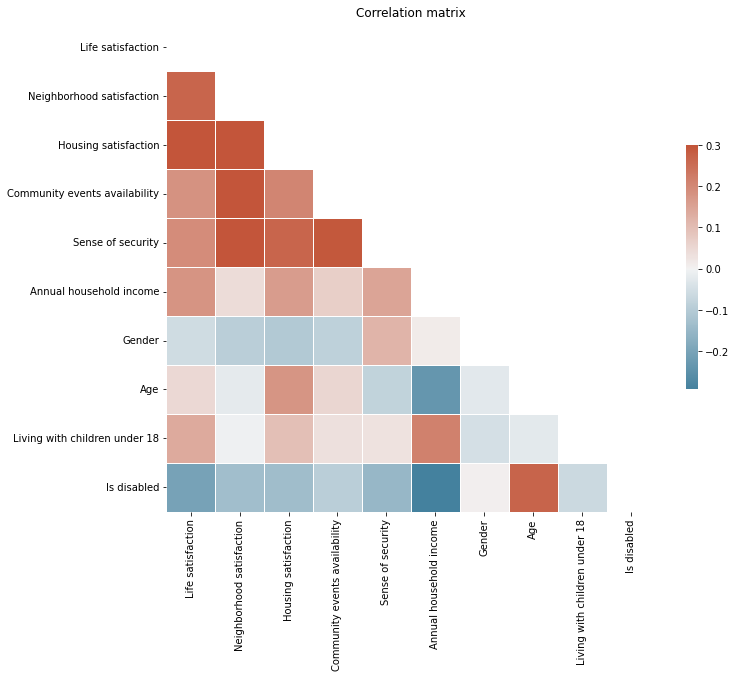

In [40]:
# Correlation between all variables
corr = df_trimed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation matrix")
plt.show()

From corelation matrix we can see that on direct level correlation between chosen variables is not very strong. Such behaviour is desired because ordered logistic regression in our models requires low association between features.

## 2. Priors and validation

### Ordered logistics regression

We have decied to use ordered logistics regression analysis in order to determine factors affecting happines levels. It has been used before for such [task](https://dergipark.org.tr/en/download/article-file/2072316).

Ordered logistic reggression model is used when varabile has more than two categories and is sortable. In our case we have 10 diffrent levels of happines, and we can sort them from least happy to most happy. Other use cases for such models would be predicting education level or descriptions of parameters with outcomes as: "poor", "fair", "good", "very good", and "excellent".

We are loooking for values of cutpoints which would split values of linear combination for given person into 10 categories.

### Chosing Priors

The chosen priors distribution (for predictors coefficients) is the normal distribution with mean 0 and standard deviation 1, except for the cutpoints which have standard deviation 3. We have decided to use such uninformative ("weak") priors because we couldn't find any specific values for parameters. This was not surprising because in the social sciences it is hard to come up with scientific constants or specific formulas to describe feelings. We therefore assume the true value of the coefficient can plausibly be anywhere on a relatively wide range on the real number line. 

Values for c - cutpoints in prior check are defined in model because ordered vector can`t be used in generated quantities block.

### Prior predictive checks

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


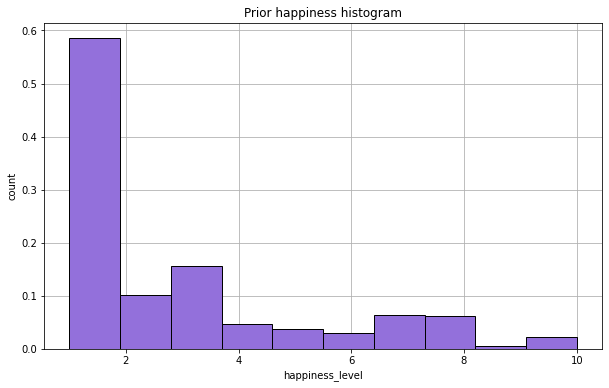

In [41]:
m1_ppc = CmdStanModel(stan_file='stan_files/model1_ppc.stan')

rng_num =  np.random.randint(low=0, high=100)

d = {'K' : 10,
     'y' : life_satisfaction[rng_num],
     'neigh_sat' : neighborhood_satisfaction[rng_num],
     'hous_sat' : housing_satisfaction[rng_num],
     'com_even_avail' : community_events_availability[rng_num],
     'sen_of_sec' : sense_of_security[rng_num],
     'ann_hous_inc' : annual_household_income[rng_num],
     'liv_with_child' : living_with_children[rng_num],
     'is_disabled' : is_disabled[rng_num]}

# Compilation of model1_ppc.stan and get 1000 samples for 4 chains
samples = m1_ppc.sample(data=d, fixed_param=True, iter_sampling=1000, chains=4)

ppc_happy = samples.stan_variable('happy').flatten()
plt.figure(figsize=(10, 6))
x, y = np.unique(life_satisfaction, return_counts=True)
plt.hist(ppc_happy, align='mid', density=True, label='predicted', color='mediumpurple', edgecolor="black", zorder=2)
plt.title("Prior happiness histogram")
plt.xlabel("happiness_level")
plt.ylabel("count")
plt.grid(zorder=0)
plt.show()

For random choosen sample prior predictive check does not fit data very well. The main reason behind this behaviour are choosen priors. Model does not yet know that beta paramteres in vector for each categorical varaible could be correlated.

### Prior parameteres check

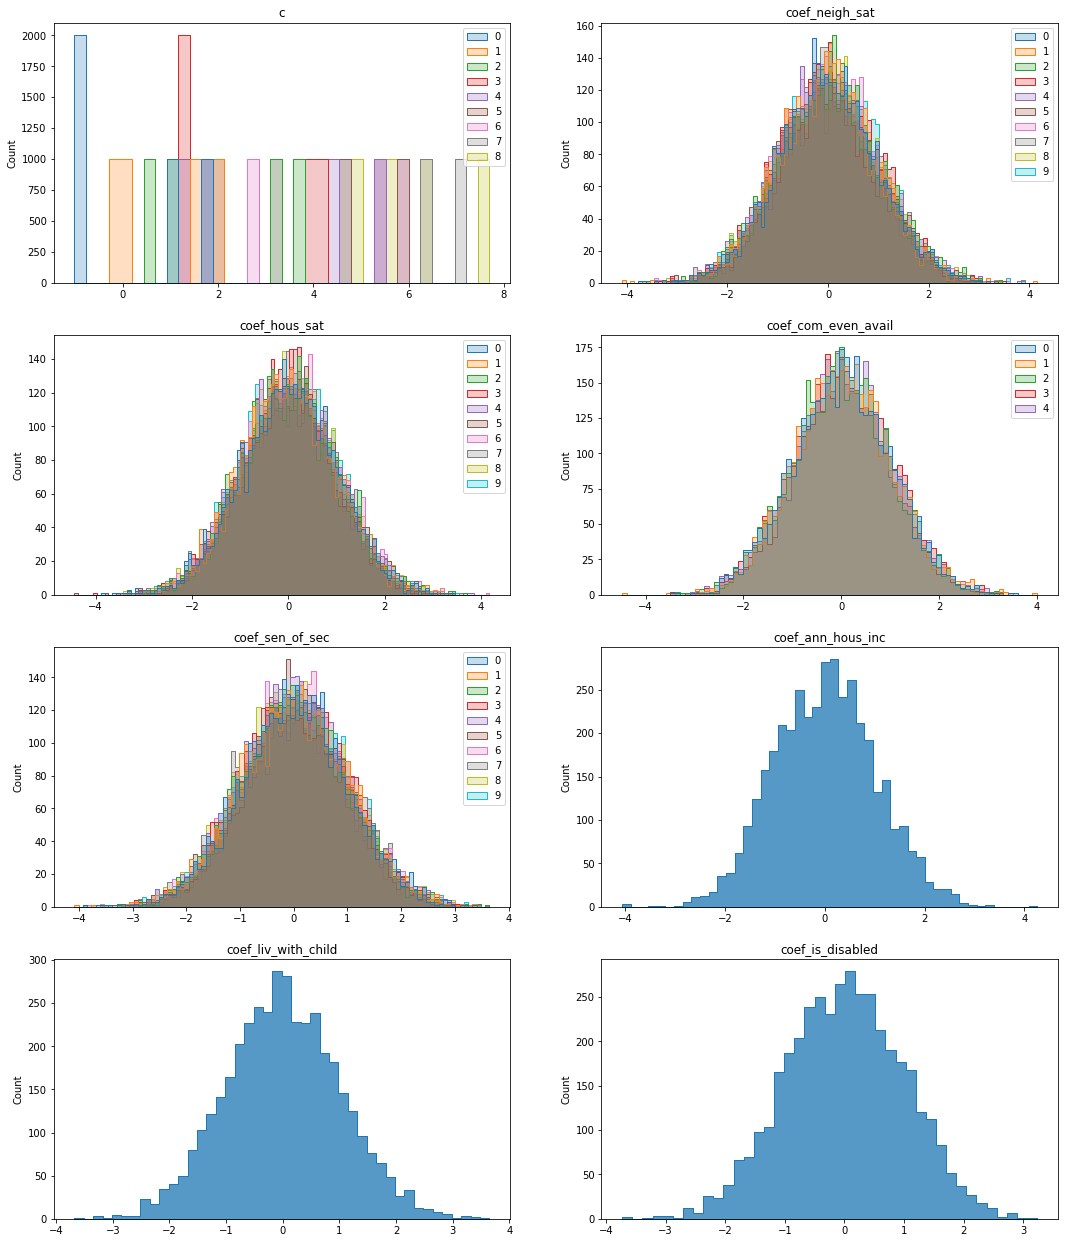

In [42]:
lst = ['c','coef_neigh_sat','coef_hous_sat','coef_com_even_avail','coef_sen_of_sec','coef_ann_hous_inc','coef_liv_with_child','coef_is_disabled']

fig, axs = plt.subplots(4, 2, figsize=(18, 22))
for ax, param in zip(axs.flat, lst):
    coeffs = samples.stan_variable(param)
    sns.histplot(ax=ax, data=coeffs, element="step")
    ax.set_title(param)

plt.show()

Distribution of coefficients in prior model are consistent with those specfied in model.

C - cutoff does not change because it can only be specified in model (it is an oredered vector), and we do not want to update it in prior predictive check.

## 3. First model

### Model description

This is a Bayesian ordinal logistic regression model implemented in Stan, which aims to predict an ordinal outcome based on seven predictors, including neighborhood satisfaction, housing satisfaction, community events availability, sense of security, annual household income, living with children, and disability status. The model, defined by specific cutpoints and coefficients for each predictor, assumes priors to follow a normal distribution. The estimation process uses a loop to run through all observations, calculating the sum of each predictor times its respective coefficient for the ordinal logistic regression model. 

#### Inputs:
* N - Number of samples 
* K - Number of ordinal categories
* y[N] - Ordinal outcome
* neigh_sat[N] - Predictor 1 (neighborhood_satisfaction)
* hous_sat[N] - Predictor 2 (housing_satisfaction)
* com_even_avail[N] - Predictor 3 (community_events_availability)
* sen_of_sec[N] - Predictor 4 (sense_of_security)
* ann_hous_inc[N] - Predictor 5 (annual_household_income)
* liv_with_child[N] - Predictor 6 (living_with_children)
* is_disabled[N] - Predictor 7 (is_disabled)

#### Parameters: 
* c[K-1] - Cutpoints
* coef_neigh_sat[10] - Coefficient 1 (neighborhood_satisfaction)
* coef_hous_sat[10] - Coefficient 2 (housing_satisfaction)
* coef_com_even_avail[5] - Coefficient 3 (community_events_availability)
* coef_sen_of_sec[10] - Coefficient 4 (sense_of_security)
* coef_ann_hous_inc - Coefficient 5 (annual_household_income)
* coef_liv_with_child - Coefficient 6 (living_with_children)
* coef_is_disabled - Coefficient 7 (is_disabled)

#### Formulas:
```
happy = ordered_logistic(coef_neigh_sat[neigh_sat] + 
                         coef_hous_sat[hous_sat] +        
                         coef_com_even_avail[com_even_avail] +
                         coef_sen_of_sec[sen_of_sec] +
                         coef_ann_hous_inc * ann_hous_inc +
                         coef_liv_with_child * liv_with_child +
                         coef_is_disabled * is_disabled, c)

$$c \sim Normal(0, 3)$$
$$coef_{neigh sat} \sim Normal(0, 1)$$
$$coef_{hous sat} \sim Normal(0, 1)$$
$$coef_{com even avail} \sim Normal(0, 1)$$
$$coef_{sen of sec} \sim Normal(0, 1)$$
$$coef_{ann hous inc} \sim Normal(0, 1)$$
$$coef_{liv with child} \sim Normal(0, 1)$$
$$coef_{is disabled} \sim Normal(0, 1)$$

### Model fit and evaluation

In first model we have decied to use neighbourhhood satisfaction, housing satisafcion, rating of availability of community events, sens of security, disability and income and whether or not are you living with childern under 18.

Happines is an ordered categorical variable, therefore we have used ordered logistic model. This model is suited for categorical varaible, we are searching beta parameters for each coefficient and cutoffpoints which define values in which the level of happiness changes.

In [43]:
model1_fit = CmdStanModel(stan_file='stan_files/model1_fit.stan')

d = {'N' : N,
     'K' : 10,
     'y' : life_satisfaction,
     'neigh_sat' : neighborhood_satisfaction,
     'hous_sat' : housing_satisfaction,
     'com_even_avail' : community_events_availability,
     'sen_of_sec' : sense_of_security,
     'ann_hous_inc' : annual_household_income,
     'liv_with_child' : living_with_children,
     'is_disabled' : is_disabled}

# Compilation of test2.stan and get 1000 samples
samples1 = model1_fit.sample(data=d, iter_sampling=1000, iter_warmup=1000, chains=4)
print(samples1.diagnose())

INFO:cmdstanpy:compiling stan file /home/Final project/stan_files/model1_fit.stan to exe file /home/Final project/stan_files/model1_fit
INFO:cmdstanpy:compiled model executable: /home/Final project/stan_files/model1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmp083cas7h/tmp_kwwsvga.hpp /tmp/tmp083cas7h/tmp_kwwsvga.stan
Warning in '/tmp/tmp083cas7h/tmp_kwwsvga.stan', line 7, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmp083cas7h/tmp_kwwsvga.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmp083cas7h


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpiqr3j8nb/model1_fit-20230720165930_1.csv, /tmp/tmpiqr3j8nb/model1_fit-20230720165930_2.csv, /tmp/tmpiqr3j8nb/model1_fit-20230720165930_3.csv, /tmp/tmpiqr3j8nb/model1_fit-20230720165930_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



### Posterior anlysis

Below we can see the distribution of happines, cutoffpoints and beta parameters of the model. Fitting proces caused changes in parameteres. The cooeficients make sens from logical point of view, but it would be hard to get this knowledge apriori. We would expected to see more ordered structure for categorical parrameters like housing satisafction or sense of security. It is still visible that in most of categorical parameteres higher values correspond to higher sense of security.

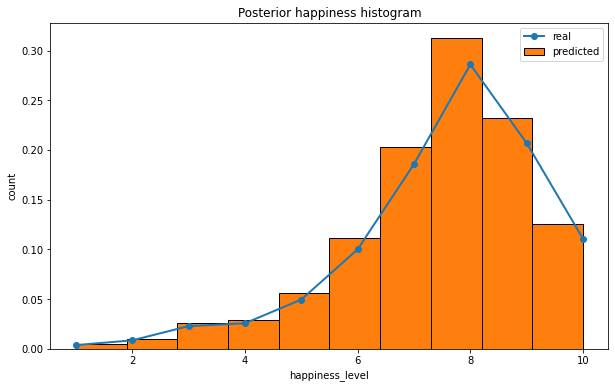

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,c[1],c[2],c[3],...,log_lik[1040],log_lik[1041],log_lik[1042],log_lik[1043],log_lik[1044],log_lik[1045],log_lik[1046],log_lik[1047],log_lik[1048],log_lik[1049]
0,-1857.04,0.876799,0.059230,6.0,63.0,0.0,1872.37,-5.87482,-5.01430,-3.81998,...,-1.82202,-2.32084,-1.21341,-1.08320,-1.73052,-1.16337,-3.05869,-1.73080,-2.10321,-3.29450
1,-1856.73,0.991811,0.059230,6.0,63.0,0.0,1883.72,-5.77041,-3.50517,-2.48000,...,-1.85006,-1.91667,-1.18100,-1.12319,-2.58608,-1.11644,-3.65807,-1.84570,-2.29212,-3.06212
2,-1851.70,0.984535,0.059230,6.0,63.0,0.0,1875.05,-5.31038,-3.47341,-2.39685,...,-1.74879,-1.83653,-1.18731,-1.14807,-1.78257,-1.13719,-3.65002,-1.73708,-2.02211,-2.87900
3,-1849.71,0.996348,0.059230,6.0,63.0,0.0,1869.94,-4.28594,-3.29905,-2.31579,...,-1.70240,-2.17921,-1.09980,-1.04413,-2.32019,-1.21054,-3.18805,-1.99208,-2.29874,-3.44463
4,-1845.39,0.997525,0.059230,6.0,63.0,0.0,1871.29,-4.18286,-3.10999,-2.02109,...,-1.62687,-2.24470,-1.19157,-1.11511,-1.91933,-1.10184,-3.76329,-1.95981,-2.20488,-2.54350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1858.46,0.794880,0.049675,8.0,255.0,0.0,1876.65,-4.46954,-3.01187,-2.02075,...,-1.54433,-2.32119,-1.17174,-1.05445,-1.52134,-1.17539,-3.40164,-2.30968,-2.03750,-3.24648
3996,-1855.02,0.949637,0.049675,8.0,255.0,0.0,1882.52,-4.87436,-3.88022,-2.60799,...,-1.75502,-2.06465,-1.11491,-1.05522,-1.97037,-1.06688,-3.97429,-1.80552,-2.05720,-2.79894
3997,-1855.45,0.993302,0.049675,6.0,63.0,0.0,1873.58,-4.85811,-3.60794,-2.43146,...,-1.61993,-2.25498,-1.19767,-1.10436,-2.06177,-1.29494,-3.09319,-2.02620,-2.01496,-2.84492
3998,-1861.34,0.861039,0.049675,7.0,127.0,0.0,1882.14,-6.21580,-4.80622,-3.75667,...,-1.56533,-2.44842,-1.20695,-1.10949,-2.44575,-1.38532,-4.22162,-1.82643,-2.07337,-2.47405


In [44]:
model1_happy = samples1.stan_variable('happy').flatten()

plt.figure(figsize=(10, 6))
x, y = np.unique(life_satisfaction, return_counts=True)
plt.plot(x, y/sum(y), marker='o', linewidth=2, label='real')
plt.hist(model1_happy, align='mid', density=True, label='predicted', edgecolor="black")
plt.title("Posterior happiness histogram")
plt.xlabel("happiness_level")
plt.ylabel("count")
plt.legend()
plt.show()

df_res = samples1.draws_pd()
display(df_res)

As we can see on the plot, distribution of target samples in posterior model fits distribution in our dataset.

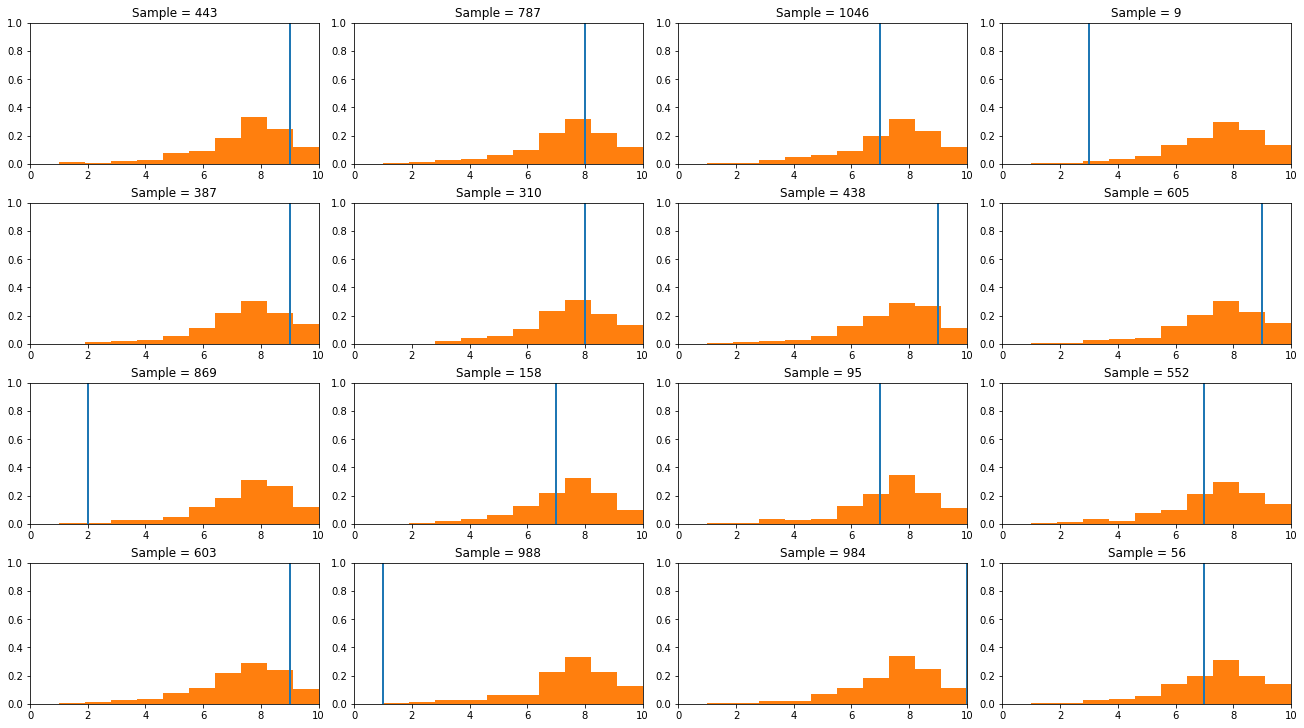

In [45]:
model_happy = samples1.stan_variable('happy')
arr = np.random.randint(low=1, high=N, size = 16)

fig, axs = plt.subplots(4, 4, figsize=(18, 10), layout='constrained')
for ax, sample in zip(axs.flat, arr):
    x = life_satisfaction[sample]
    ax.plot([x,x], [-0.2,1.2], linewidth=2, label='real')
    ax.hist(model_happy[sample], align='mid', density=True, label='predicted')
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 1])
    ax.set_title(f"Sample = {sample}")
plt.show()

When looking for random chossen specfic indivdulas we can see that the distrbution does not follow the real value, this means that model is overfitted. Possible reason for this phenomena could be using to many categorical variables in ordered logistic model.


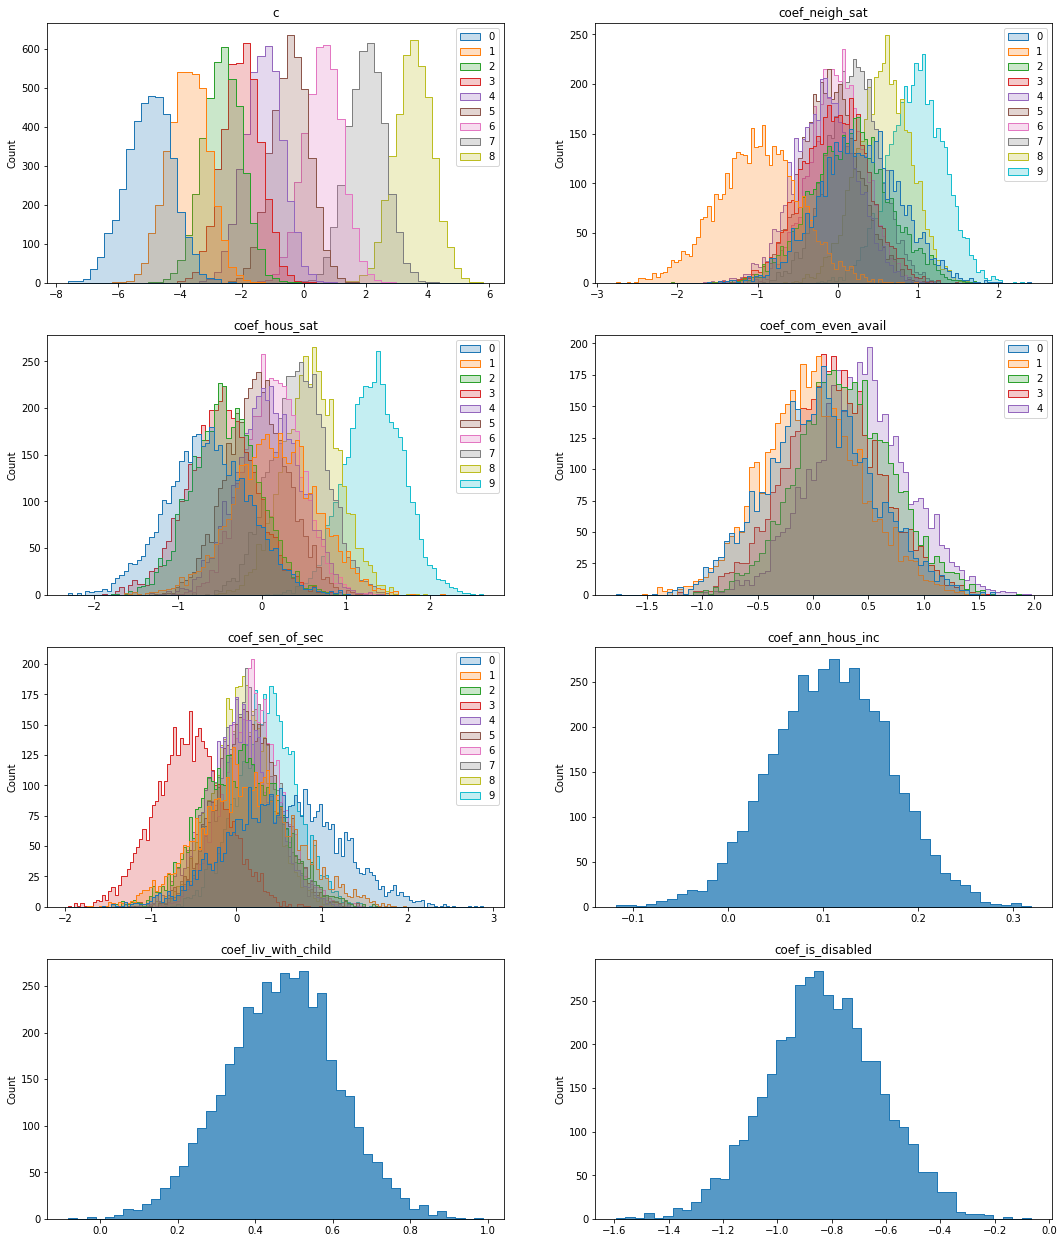

In [46]:
lst = ['c','coef_neigh_sat','coef_hous_sat','coef_com_even_avail','coef_sen_of_sec',
       'coef_ann_hous_inc','coef_liv_with_child','coef_is_disabled']

fig, axs = plt.subplots(4, 2, figsize=(18, 22))
for ax, param in zip(axs.flat, lst):
    coeffs = samples1.stan_variable(param)
    sns.histplot(ax=ax, data=coeffs, element="step")
    ax.set_title(param)

plt.show()

For most paramteters distributions are narrower. Mean value also has changed, but we expected it to change because we did not have apriori knowledge of their impact on life satisafction. Most of them make sense, people with more money, or childer can be more happy. Beta coffecints for categorical varaiables also seem reasonable.

On our the first approach we encountered issue during sampling which was propably triggered by using ordered vectors for all coefficients. To fix this problem we decided to use normal vectors witch resulted in better coefficients spread. Another minor problem was an fixed_parameter flag that was set to True. This initially blocked the change of coefficients.

## 4. Second model

### Model description
For second model we have added age and gender of person. Age and gender can have impact on human happines. As described in [A Research Note: Happiness by Age is More Complex than U-Shaped](https://doi.org/10.1007/s10902-016-9830-1).

#### Inputs:
* N - Number of samples 
* K - Number of ordinal categories
* y[N] - Ordinal outcome
* neigh_sat[N] - Predictor 1 (neighborhood_satisfaction)
* hous_sat[N] - Predictor 2 (housing_satisfaction)
* com_even_avail[N] - Predictor 3 (community_events_availability)
* sen_of_sec[N] - Predictor 4 (sense_of_security)
* ann_hous_inc[N] - Predictor 5 (annual_household_income)
* gender[N] - Predictor 6 (gender)
* age[N] - Predictor 7 (age)
* liv_with_child[N] - Predictor 8 (living_with_children)
* is_disabled[N] - Predictor 9 (is_disabled)

#### Parameters: 
* c[K-1] - Cutpoints
* coef_neigh_sat[10] - Coefficient 1 (neighborhood_satisfaction)
* coef_hous_sat[10] - Coefficient 2 (housing_satisfaction)
* coef_com_even_avail[5] - Coefficient 3 (community_events_availability)
* coef_sen_of_sec[10] - Coefficient 4 (sense_of_security)
* coef_ann_hous_inc - Coefficient 5 (annual_household_income)
* coef_gender[N] - Coefficient 6 (gender)
* coef_age[N] - Coefficient 7 (age)
* coef_liv_with_child - Coefficient 8 (living_with_children)
* coef_is_disabled - Coefficient 9 (is_disabled)

#### Formulas:
```
happy = ordered_logistic(coef_neigh_sat[neigh_sat] + 
                         coef_hous_sat[hous_sat] +        
                         coef_com_even_avail[com_even_avail] +
                         coef_sen_of_sec[sen_of_sec] +
                         coef_ann_hous_inc * ann_hous_inc +
                         coef_gender[gender[n]] +
                         coef_age[age[n]] +
                         coef_liv_with_child * liv_with_child +
                         coef_is_disabled * is_disabled, c)

$$c \sim Normal(0, 3)$$
$$coef_{neigh sat} \sim Normal(0, 1)$$
$$coef_{hous sat} \sim Normal(0, 1)$$
$$coef_{com even avail} \sim Normal(0, 1)$$
$$coef_{sen of sec} \sim Normal(0, 1)$$
$$coef_{ann hous inc} \sim Normal(0, 1)$$
$$coef_{liv with child} \sim Normal(0, 1)$$
$$coef_{is disabled} \sim Normal(0, 1)$$
$$coef_{gender} \sim Normal(0, 1)$$
$$coef_{age} \sim Normal(0, 1)$$

### Model fit and evaluation

In [47]:
model2_fit = CmdStanModel(stan_file='stan_files/model2_fit.stan')

d = {'N' : N,
     'K' : 10,
     'y' : life_satisfaction,
     'neigh_sat' : neighborhood_satisfaction,
     'hous_sat' : housing_satisfaction,
     'com_even_avail' : community_events_availability,
     'sen_of_sec' : sense_of_security,
     'ann_hous_inc' : annual_household_income,
     'gender' : gender,
     'age' : age,
     'liv_with_child' : living_with_children,
     'is_disabled' : is_disabled}

# Compilation of test2.stan and get 1000 samples
samples2 = model2_fit.sample(data=d, iter_sampling=1000, iter_warmup=1000, chains=4)
print(samples2.diagnose())

INFO:cmdstanpy:compiling stan file /home/Final project/stan_files/model2_fit.stan to exe file /home/Final project/stan_files/model2_fit
INFO:cmdstanpy:compiled model executable: /home/Final project/stan_files/model2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmp02yyqprv/tmp0r5lff8x.hpp /tmp/tmp02yyqprv/tmp0r5lff8x.stan
Warning in '/tmp/tmp02yyqprv/tmp0r5lff8x.stan', line 7, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmp02yyqprv/tmp0r5lff8x.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmp02yyqprv


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpiqr3j8nb/model2_fit-20230720170224_1.csv, /tmp/tmpiqr3j8nb/model2_fit-20230720170224_2.csv, /tmp/tmpiqr3j8nb/model2_fit-20230720170224_3.csv, /tmp/tmpiqr3j8nb/model2_fit-20230720170224_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



### Posterior anlysis

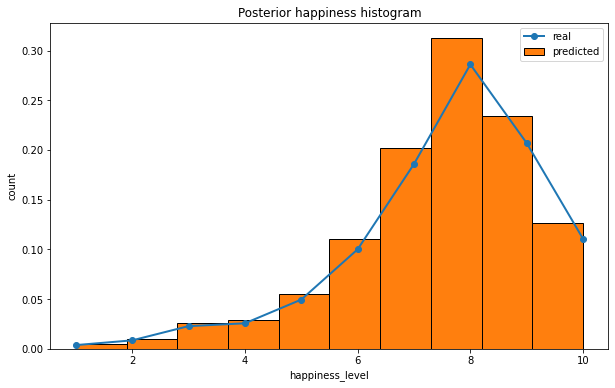

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,c[1],c[2],c[3],...,log_lik[1040],log_lik[1041],log_lik[1042],log_lik[1043],log_lik[1044],log_lik[1045],log_lik[1046],log_lik[1047],log_lik[1048],log_lik[1049]
0,-1856.91,0.991321,0.051824,6.0,63.0,0.0,1885.89,-3.43413,-2.63218,-1.21898,...,-1.83519,-2.30751,-1.35882,-1.00600,-1.40836,-1.09594,-4.23062,-2.36373,-1.69076,-3.30558
1,-1851.87,0.971570,0.051824,6.0,63.0,0.0,1886.89,-4.24328,-3.13937,-1.71487,...,-1.60945,-2.57310,-1.30743,-1.03815,-2.53157,-1.04286,-3.96041,-2.09889,-1.94374,-2.67261
2,-1854.71,0.938620,0.051824,8.0,319.0,0.0,1891.88,-5.98799,-4.83506,-3.43063,...,-1.87716,-1.49126,-1.23682,-1.04288,-2.16313,-1.10718,-3.71719,-2.20826,-2.25142,-4.00863
3,-1844.10,0.994169,0.051824,6.0,63.0,0.0,1882.30,-6.17011,-4.83906,-3.86540,...,-1.66102,-2.05420,-1.16320,-1.05861,-2.18651,-1.06865,-3.65088,-2.19081,-2.09727,-3.06429
4,-1845.83,0.838681,0.051824,6.0,63.0,0.0,1883.17,-6.21219,-4.77899,-3.86218,...,-1.84678,-2.14197,-1.23395,-1.05745,-2.07276,-1.11470,-4.05895,-2.18892,-2.29249,-3.15613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1857.62,0.867526,0.044823,6.0,63.0,0.0,1889.79,-3.17348,-2.12428,-1.22901,...,-1.42878,-2.14669,-1.19071,-1.09047,-1.99637,-1.34319,-3.51332,-2.35891,-2.07334,-3.48178
3996,-1854.36,0.959348,0.044823,6.0,127.0,0.0,1882.73,-3.69201,-2.72551,-1.77093,...,-1.59728,-1.44309,-1.33527,-1.08293,-2.37293,-1.09281,-4.39579,-2.14882,-1.82576,-3.82414
3997,-1857.96,0.998498,0.044823,8.0,255.0,0.0,1885.18,-3.60135,-2.64531,-1.72882,...,-1.34062,-1.61254,-1.32038,-1.07126,-2.12492,-1.08692,-4.22330,-2.41774,-1.81220,-3.60352
3998,-1850.22,0.981360,0.044823,6.0,63.0,0.0,1879.66,-3.71638,-2.72236,-1.44155,...,-1.86375,-1.67117,-1.14510,-1.00720,-2.01028,-1.12668,-3.86082,-2.40891,-2.19668,-3.73568


In [48]:
model2_happy = samples2.stan_variable('happy').flatten()

plt.figure(figsize=(10, 6))
x, y = np.unique(life_satisfaction, return_counts=True)
plt.plot(x, y/sum(y), marker='o', linewidth=2, label='real')
plt.hist(model2_happy, align='mid', density=True, label='predicted', edgecolor="black")
plt.title("Posterior happiness histogram")
plt.xlabel("happiness_level")
plt.ylabel("count")
plt.legend()
plt.show()

df_res = samples2.draws_pd()
display(df_res)

Similar to firs model, distrbuiton of total happines is consistent with data.

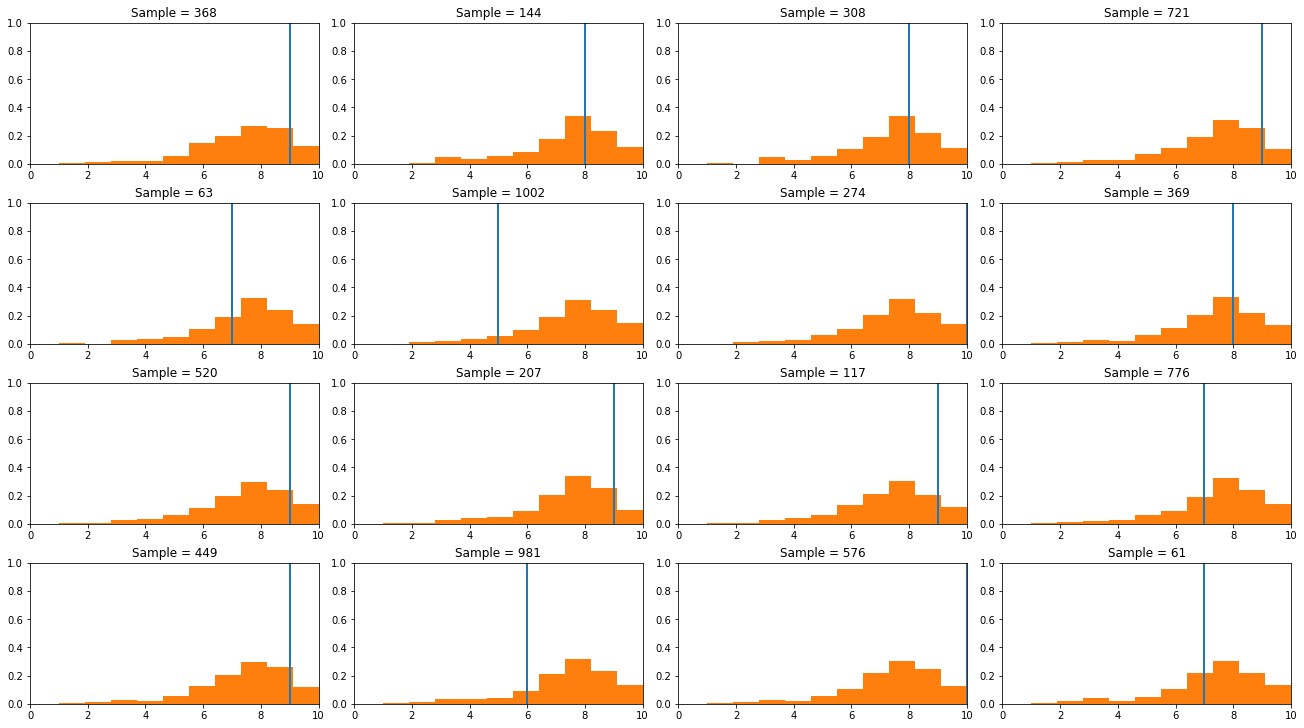

In [49]:
model2_happy = samples2.stan_variable('happy')
arr = np.random.randint(low=1, high=N, size = 16)


fig, axs = plt.subplots(4, 4, figsize=(18, 10), layout='constrained')
for ax, sample in zip(axs.flat, arr):
    x = life_satisfaction[sample]
    ax.plot([x,x], [-0.2,1.2], linewidth=2, label='real')
    ax.hist(model2_happy[sample], align='mid', density=True, label='predicted')
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 1])
    ax.set_title(f"Sample = {sample}")
plt.show()

But for random samples sadly this model is also overfitted.

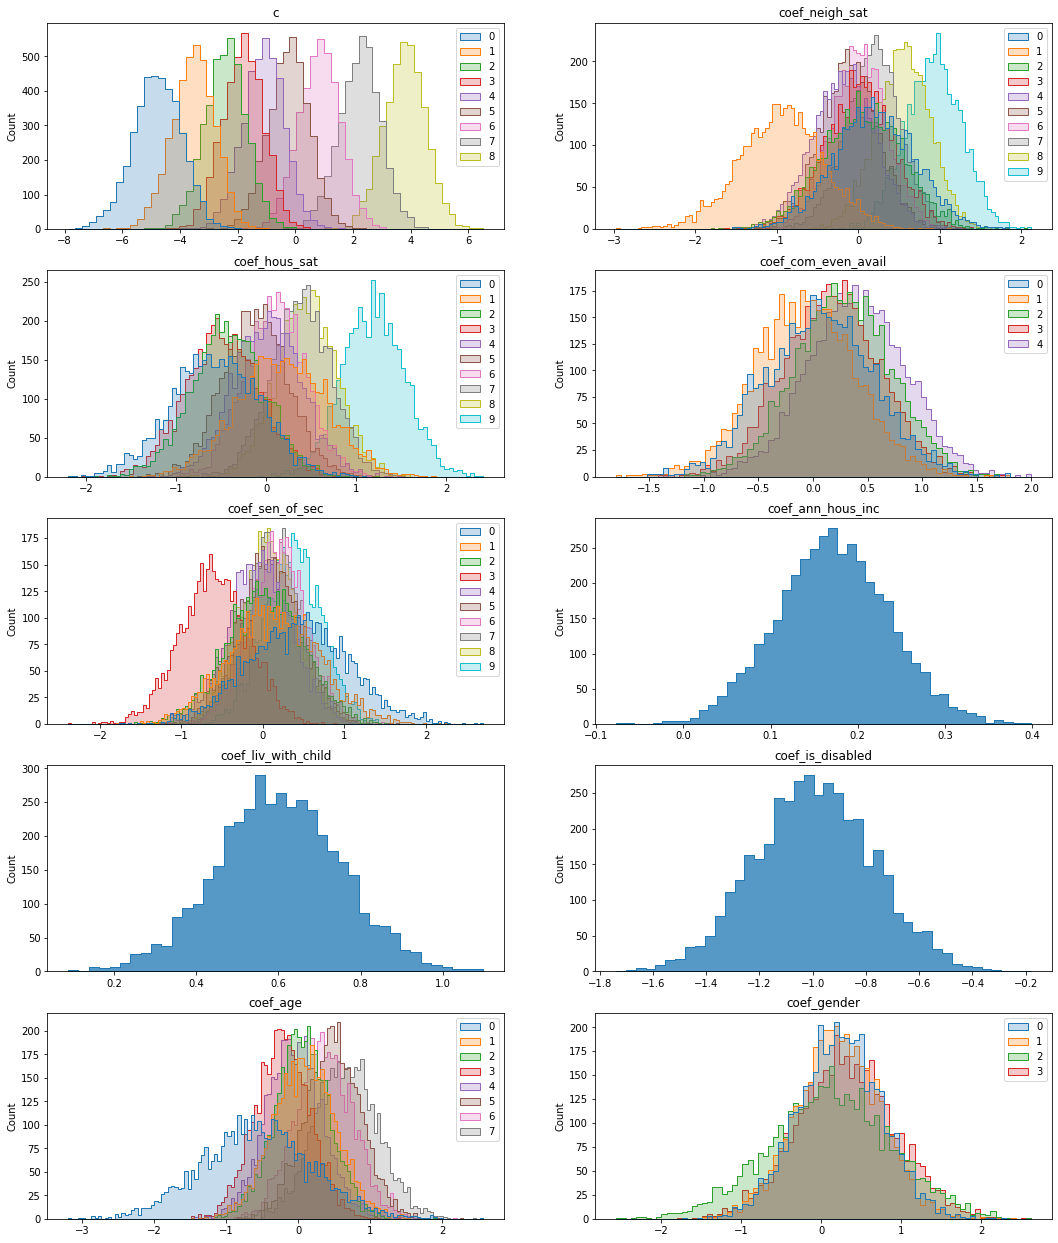

In [50]:
lst = ['c','coef_neigh_sat','coef_hous_sat','coef_com_even_avail','coef_sen_of_sec',
       'coef_ann_hous_inc','coef_liv_with_child','coef_is_disabled','coef_age','coef_gender']

fig, axs = plt.subplots(5, 2, figsize=(18, 22))
for ax, param in zip(axs.flat, lst):
    coeffs = samples2.stan_variable(param)
    sns.histplot(ax=ax, data=coeffs, element="step")
    ax.set_title(param)

plt.show()

Coefficents for second model are similar to first one. We can see mean of cooeficents for age and sex is aroud 0, it seems like age does not have impact on our model, which is not coherent with paper mentioned above. Age and gender are casues for other parameters and their impact may be transmitted through them.

## 5. Model Comparison

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


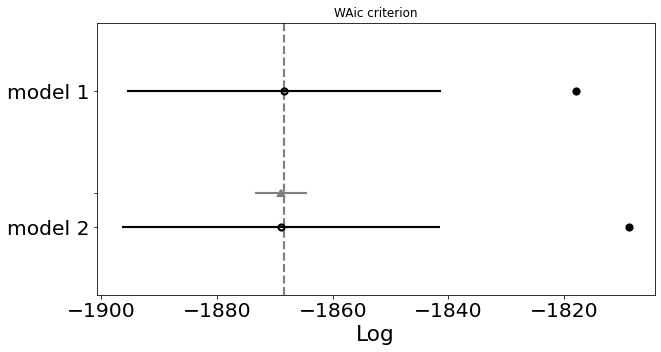

In [51]:
az_pred1 = az.from_cmdstanpy(samples1)
az_pred2 = az.from_cmdstanpy(samples2)
waic_compare = az.compare({"model 1" : az_pred1, "model 2" : az_pred2}, ic="waic")
az.plot_compare(waic_compare, figsize=(10, 5))
plt.title("WAic criterion")
plt.show()

In [52]:
waic_compare

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model 1,0,-1868.465347,50.573055,0.000000,0.520334,27.138997,0.000000,True,log
model 2,1,-1868.948570,60.253861,0.483223,0.479666,27.480812,4.433612,True,log


According to WAIC models are overlapping. Which is not expected as we have thought that adding parameters like age and gender would make the fit better.

There is one warning while calulcating the WAIC score:

UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail.

This warning can indicate model misspecification, overfitting, or other issues related to the data or modeling assumptions.

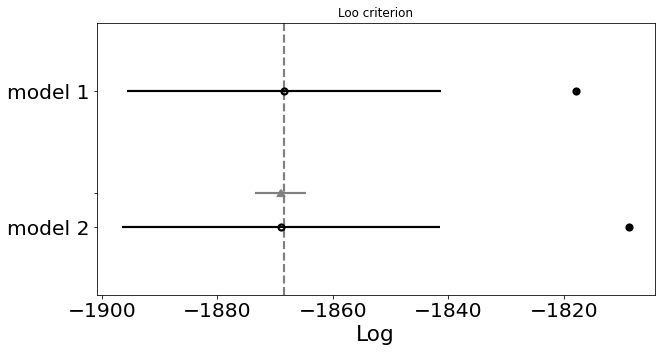

In [53]:
loo_compare = az.compare({"model 1" : az_pred1, "model 2" : az_pred2}, ic="loo")
az.plot_compare(loo_compare, figsize=(10, 5))
plt.title("Loo criterion")
plt.show()

In [54]:
loo_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model 1,0,-1868.473516,50.581224,0.000000,0.523456,27.137165,0.000000,False,log
model 2,1,-1869.019039,60.324330,0.545523,0.476544,27.482554,4.436733,False,log


Similar to WAIC models according to LOO criterion models are also overlapping. There is no winner, which we did not expect.

Loo creterion does not raise any warnings or erros.

The difference between both models is insignificant. It was surprising to learn because based on our assumptions age and gender should have a significant impact on happiness level. This could indicate more complex hidden confounds. We are content with the results, but predicting human happiness is a complex problem and we have only scratched the surface. Models require more analysis. 

It is worth mentioning that finding an appropriate dataset was a difficult task. Most available datasets contained only data summaries, we were not able to get individual responses.